In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image
from IPython.core.display import SVG
import matplotlib.pyplot as plt
import folium
from matplotlib.ticker import MaxNLocator
import json
from sklearn.manifold import TSNE

### Population

In [2]:
# Load population data
population_df = pd.read_csv('data/Population_E_All_Data_(Normalized).zip', encoding='latin-1')

In [3]:
# Create dataframe with world level population keeping relevant columns
world_population = population_df[population_df.Area=='World'][['Area', 'Year', 'Element', 'Unit', 'Value']]

# Create dataframe with low income food deficit countries population levels
food_deficit_population = population_df[population_df.Area=='Low Income Food Deficit Countries']\
[['Year', 'Element', 'Value']]

In [4]:
# Rename columns
food_deficit_population = food_deficit_population.rename(columns={'Value': 'num_people_def_countries'})

In [5]:
# Join world population dataset with low income food deficit countries population dataset on Year
world_population = pd.merge(world_population, food_deficit_population, on=['Year', 'Element'], how='inner')

In [6]:
# Compute the proportion of low income food deficit countries' populations of world population for each year
world_population['ratio_def_pop'] = world_population.num_people_def_countries/world_population.Value

In [7]:
# Limit dataset timeline up to 2017 to exclude predictive data
world_population = world_population[(world_population.Year<2018) 
                                    & (world_population.Element=='Total Population - Both sexes')]

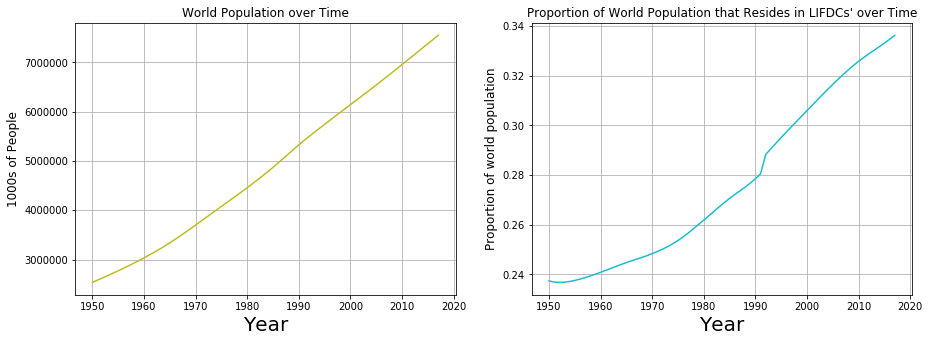

In [49]:
# Plot evolution of world population and proportion of both aforementioned sub groups over time
fig = plt.figure(figsize=(15,5))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.grid()
p2.grid()
p1.plot(world_population.Year.values, world_population.Value.values,color='#bcbd22')
p1.set_title('World Population over Time',fontsize=12)
p1.set_xlabel('Year',fontsize=20)
p1.set_ylabel('1000s of People',fontsize=12)
p2.plot(world_population.Year.values, world_population.ratio_def_pop.values,color='#17becf')#, label='Low Income Food Deficit Countries')
p2.set_title("Proportion of World Population that Resides in LIFDCs' over Time",fontsize=12)
p2.set_xlabel('Year',fontsize=20)
p2.set_ylabel('Proportion of world population',fontsize=12)
plt.show()

### Greenhouse Gas Emissions

In [14]:
# Load emissions by sector dataset
emissions_by_sector_df = pd.read_csv('data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).zip', 
                                  encoding='latin-1')

# Load agriculture emissions dataset
agriculture_emissions_df = pd.read_csv('data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip', 
                                       encoding='latin-1')

In [15]:
# Extract into a dataframe the latest data for different sectors' share in total global emissions
emissions_world_sectors = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                & (emissions_by_sector_df.Area=='World')
                                                & (emissions_by_sector_df.Year==emissions_by_sector_df.Year.max())]

In [16]:
sectors = ['Energy (energy, manufacturing and construction industries and fugitive emissions)', 'Transport', 
           'Residential, commercial, institutional and AFF', 'Industrial processes and product use', 'Waste', 
           'Other sources', 'International bunkers', 'Agriculture total', 'Land use sources']

In [17]:
# Filter emissions by sector dataframe to the above list of sectors
pie_df = emissions_world_sectors[emissions_world_sectors.Item.isin(sectors)]

In [19]:
# Extract into a dataframe the historic values of agriculture's share in total world emissions
world_ag_emissions_hist = emissions_by_sector_df[(emissions_by_sector_df.Element=='Share of sector in total emissions')
                                                 & (emissions_by_sector_df.Area=='World')
                                                 & (emissions_by_sector_df.Item=='Agriculture total')]

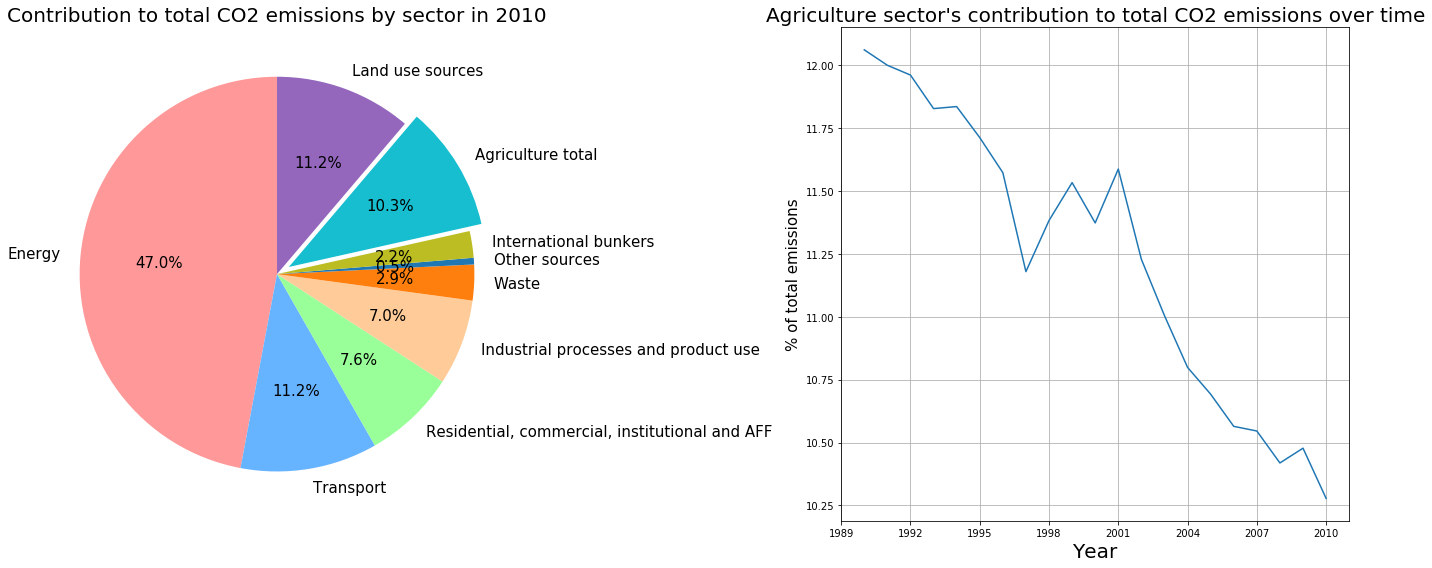

In [47]:
# Plot latest sector contributions to global emissions and the historic evolution of agriculture's share
fig = plt.figure(figsize=(20,8))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff7f0e','#1f77b4','#bcbd22','#17becf','#9467bd']
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.grid()
p2.grid()
sector_labels = sectors.copy()
sector_labels[0] = 'Energy'
p1.pie(pie_df.Value.values, explode=[0,0,0,0,0,0,0,0.07,0], colors=colors,labels=sector_labels, autopct='%1.1f%%', startangle=90, 
       textprops={'fontsize': 15})
p1.set_title('Contribution to total CO2 emissions by sector in ' + str(pie_df.Year.max()), fontsize=20)
p2.plot(world_ag_emissions_hist.Year.values, world_ag_emissions_hist.Value.values)
p2.set_xlabel('Year', fontsize=20)
p2.set_ylabel('% of total emissions', fontsize=15)
p2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2.set_title("Agriculture sector's contribution to total CO2 emissions over time", fontsize=20)
plt.tight_layout(w_pad=1)
plt.show()

In [3]:
# Load agriculture emissions dataset
agriculture_emissions_df = pd.read_csv('data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).zip', 
                                       encoding='latin-1')

In [4]:
# Extract into a dataframe nominal values of agriculture CO2, CO2eq of CH4 and CO2eq of N2O emissions
world_agriculture_emissions = agriculture_emissions_df[(agriculture_emissions_df.Area=='World') 
                                                       & ~(agriculture_emissions_df.Element.isin(['Emissions (CH4)', 'Emissions (N2O)']))
                                                       & (agriculture_emissions_df.Item=='Agriculture total')
                                                       & (agriculture_emissions_df.Year<2018)]

In [5]:
# Extract list of years and gas types for plot below
xticks = world_agriculture_emissions.Year.drop_duplicates().sort_values().values
labels = world_agriculture_emissions.Element.drop_duplicates().values

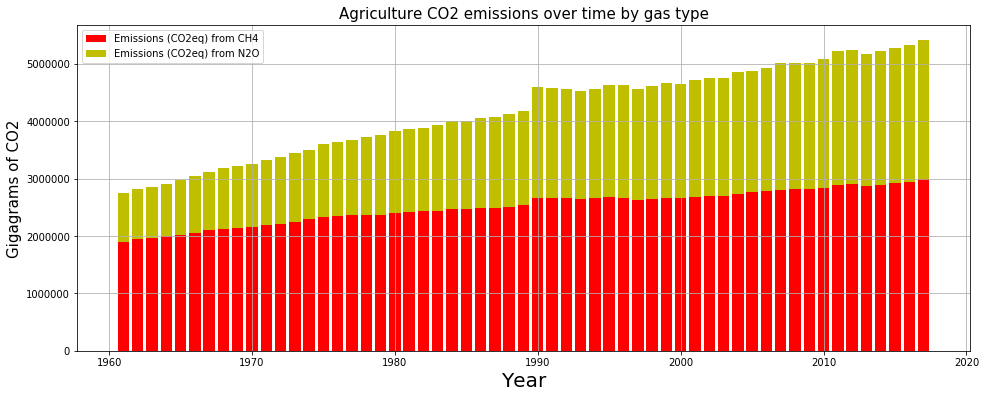

In [6]:
# Plot world's CO2eq emissions of agriculture sector over time split by CO2eq of CH4 and CO2eq of N2O
plt.figure(figsize=(16,6))
plt.grid()
p1 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='r', label=labels[1])
p2 = plt.bar(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[2]].Value.values, 
             bottom=world_agriculture_emissions[world_agriculture_emissions.Element==labels[1]].Value.values, 
             color='y', label=labels[2])
plt.title('Agriculture CO2 emissions over time by gas type',fontsize=15)
plt.ylabel('Gigagrams of CO2',fontsize=15)
plt.xlabel('Year',fontsize=20)
plt.legend()
plt.show()

In [30]:
# Update previously computed world population dataframe to include population in number of people rather than in 1000s
population_hist = world_population[['Year', 'Value']].copy()
population_hist['Population'] = 1000 * population_hist.Value

In [31]:
# Join world agricultural emissions dataframe to population dataframe on year to have both on joint timeline
agriculture_co2_emissions = pd.merge(population_hist[['Year', 'Population']], 
                                     world_agriculture_emissions[world_agriculture_emissions.Element==labels[0]],
                                     on='Year')

agriculture_co2_emissions = agriculture_co2_emissions[['Year', 'Population', 'Area', 'Element', 'Unit', 'Value']]

In [32]:
# Join in data relating to new emissions starting in 1990 computed above
agriculture_co2_emissions = pd.merge(agriculture_co2_emissions, new_emissions_df, 
                                     on='Year', how='left', suffixes=('', '_new')).copy()

In [33]:
# For years prior to 1990 set new emissions value to 0
agriculture_co2_emissions.loc[agriculture_co2_emissions.Value_new.isnull(), 'Value_new'] = 0

# Compute total world agricultural CO2eq emissions for each year excluding the new emissions starting in 1990
agriculture_co2_emissions['Value'] = agriculture_co2_emissions.Value - agriculture_co2_emissions.Value_new

In [34]:
# Compute CO2eq emissions per capita
agriculture_co2_emissions['ag_co2_pc'] = agriculture_co2_emissions.Value / agriculture_co2_emissions.Population

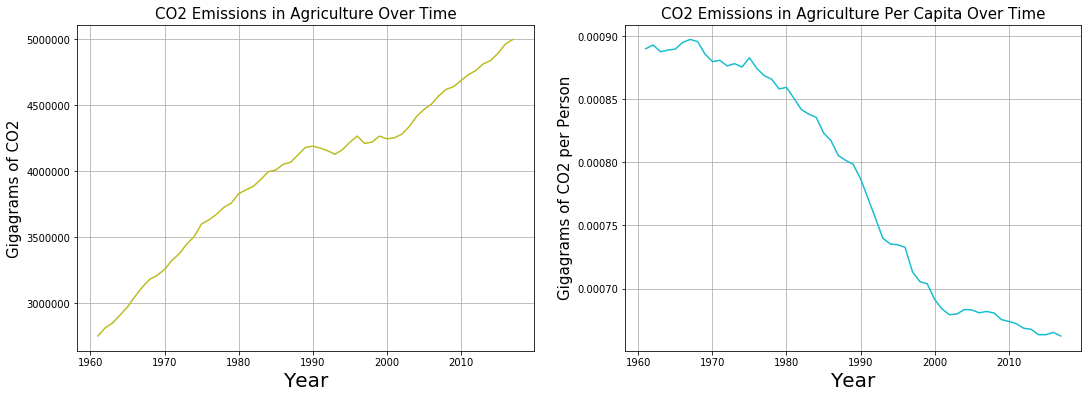

In [38]:
# Plot nominal and per capita CO2eq world agricultural emissions over time excluding new emissions
fig = plt.figure(figsize=(18,6))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.grid()
p2.grid()
p1.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.Value.values,color='#bcbd22')
p2.plot(agriculture_co2_emissions.Year.values, agriculture_co2_emissions.ag_co2_pc.values,color='#17becf')
p1.set_xlabel('Year',fontsize=20)
p1.set_ylabel('Gigagrams of CO2',fontsize=15)
p1.set_title('CO2 Emissions in Agriculture Over Time',fontsize=15)
p2.set_xlabel('Year',fontsize=20)
p2.set_ylabel('Gigagrams of CO2 per Person',fontsize=15)
p2.set_title('CO2 Emissions in Agriculture Per Capita Over Time',fontsize=15)
plt.show()

### Forest Area

In [10]:
# Load the land area dataset
land_df = pd.read_csv('data/fao_data_land_data.zip', encoding='latin-1')

In [18]:
# Load the newer version of the land area dataset
land_df = pd.read_csv('data/Inputs_LandUse_E_All_Data_(Normalized).zip', encoding='latin-1')

In [20]:
# Load country metadata mapping country groups to countries
country_metadata = pd.read_csv('data/FAOSTAT_data_11-19-2019.csv')

In [21]:
# Extract list of countries and continents from the above dataset
countries = country_metadata.Country.drop_duplicates().values
continents = country_metadata[(country_metadata['Country Group Code']>5000) & (country_metadata['Country Group Code']%100==0)]
continents = continents['Country Group'].drop_duplicates().values

In [22]:
# Extract latest country area data for each country
land_per_country = land_df[(land_df.Area.isin(countries)) & (land_df.Element=='Area') 
                           & (land_df.Item=='Country area') & (land_df.Year==land_df.Year.max())]

# Extract latest forest area data for each country
forest_per_country = land_df[(land_df.Area.isin(countries)) & (land_df.Element=='Area') 
                             & (land_df.Item=='Forest land')]

# Extract latest carbon stock in living biomass data for each country
carbon_stock_per_country = land_df[(land_df.Area.isin(countries)) 
                                   & (land_df.Element=='Carbon stock in living biomass')]

In [25]:
# Add country codes for each country in order to plot map in Folium
country_to_code = country_metadata[['Country Code', 'ISO3 Code']].drop_duplicates().set_index('Country Code')
cspc_latest = pd.merge(carbon_stock_per_country, country_to_code, left_on='Area Code', right_index=True, how='left')

In [26]:
# We noticed that the country code of South Sudan did not correspond to the code expected by folium so we update it
cspc_latest.loc[cspc_latest['Area']=='South Sudan', 'ISO3 Code'] = 'SDS'

In [27]:
world_forest = land_df[(land_df.Item=='Forest land') & (land_df.Area=='World')]
world_forest_area = world_forest[world_forest.Element=='Area']
world_forest_cs = world_forest[world_forest.Element=='Carbon stock in living biomass']

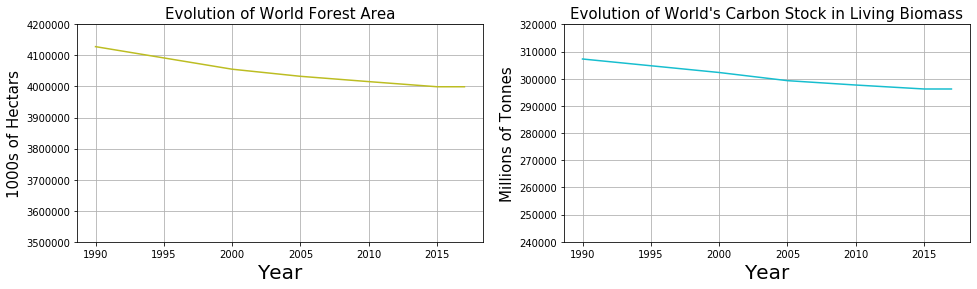

In [88]:
# Plot nominal and per capita CO2eq world agricultural emissions over time excluding new emissions
fig = plt.figure(figsize=(16,4))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.grid()
p2.grid()
p1.plot(world_forest_area.Year.values, world_forest_area.Value.values,color='#bcbd22')
p2.plot(world_forest_cs.Year.values, world_forest_cs.Value.values,color='#17becf')
p1.set_ylim([3500000,4200000])
p2.set_ylim([240000, 320000])
p1.set_xlabel('Year',fontsize=20)
p1.set_ylabel('1000s of Hectars',fontsize=15)
p1.set_title('Evolution of World Forest Area',fontsize=15)
p2.set_xlabel('Year',fontsize=20)
p2.set_ylabel('Millions of Tonnes',fontsize=15)
p2.set_title("Evolution of World's Carbon Stock in Living Biomass",fontsize=15)
plt.show()

In [78]:
world_forest_decrease = ((world_forest_area[world_forest_area.Year==world_forest_area.Year.min()].Value.values \
                        - world_forest_area[world_forest_area.Year==world_forest_area.Year.max()].Value.values) \
                        / world_forest_area[world_forest_area.Year==world_forest_area.Year.min()].Value.values)[0]

In [79]:
world_carbonstock_decrease = ((world_forest_cs[world_forest_cs.Year==world_forest_cs.Year.min()].Value.values \
                            - world_forest_cs[world_forest_cs.Year==world_forest_cs.Year.max()].Value.values) \
                            / world_forest_cs[world_forest_cs.Year==world_forest_cs.Year.min()].Value.values)[0]

In [80]:
print('Decrease of world forest area as percentage of level in 1990: ', world_forest_decrease)
print('Decrease of world forest carbon stock in biomass as percentage of level in 1990: ', world_carbonstock_decrease)

Decrease of world forest area as percentage of level in 1990:  0.03128087022915876
Decrease of world forest carbon stock in biomass as percentage of level in 1990:  0.03591410250475208


We can see that both have decreased by slightly more than 3% since 1990. Although this number might seem low it is a noteable decrease for the observed time period. Additionally, it is worth observing that even though both share a similar decreasing trend, they have decreased slightly differently proportionally indicating that not all forest share the same carbon absorbing capabilities.

In [28]:
world_map = 'data/world_countries.json'
forest_map = folium.Map(location=[40, 15], zoom_start=2)
folium.Choropleth(
    geo_data=world_map,
    data=cspc_latest,
    columns=['ISO3 Code', 'Value'],
    key_on='feature.id',
    fill_color='YlGn', 
    fill_opacity=0.9, 
    line_opacity=0.2,
    nan_fill_color='grey',
    legend_name='Millions of tonnes in carbon stock in living biomass'
).add_to(forest_map)
forest_map

In [81]:
green_countries = ['Russian Federation', 'Brazil', 'Democratic Republic of the Congo', 
                   'United States of America', 'Canada', 'Indonesia']

In [83]:
# Extract forest area data for the chosen subset of countries starting in 1992 as Russia before then was the USSR
green_countries_forests = forest_per_country[(forest_per_country.Area.isin(green_countries)) 
                                             & (forest_per_country.Year>1991)].copy()

In [84]:
# Create dict with forest area in 1992 for select subset of countries
base_area = {k: v for (k,v) in green_countries_forests[green_countries_forests.Year==1992][['Area', 'Value']].values}

# Normalize the forest area levels for each country each year according to their respective baselines
green_countries_forests['Value_Norm'] = green_countries_forests.apply(lambda row: 100*row.Value/base_area.get(row.Area),
                                                                  axis=1)

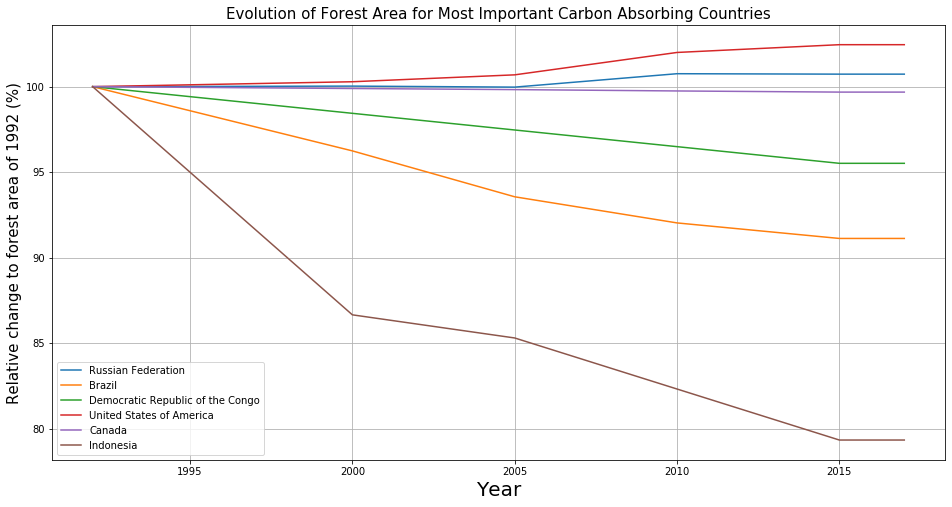

In [87]:
# Plot evolution of forest area for each country in chosen subset
plt.figure(figsize=(16,8))
plt.grid()
for g in green_countries:
    plt.plot(green_countries_forests[green_countries_forests.Area==g].Year.values,
             green_countries_forests[green_countries_forests.Area==g].Value_Norm.values, label=g)
plt.legend()
plt.xlabel('Year',fontsize=20)
plt.ylabel('Relative change to forest area of 1992 (%)',fontsize=15)
plt.title('Evolution of Forest Area for Most Important Carbon Absorbing Countries',fontsize=15)
plt.show()

In [29]:
def food_type(food_item):
    """
    Attribute food item to a type
    """
    if food_item in meat:
        return 'meat'
    elif food_item in milk:
        return 'milk'
    return 'rice or cereals'

In [31]:
# Load emissions data
emissions_df = pd.read_csv('data/Environment_Emissions_intensities_E_All_Data_(Normalized).zip', encoding='latin-1')
emissions_df = emissions_df[emissions_df.Area != 'China']

In [32]:
# Define group of items
world_emissions_intensity = emissions_df[(emissions_df.Element == 'Emissions intensity') & 
                                         (emissions_df.Area == 'World')]
items = world_emissions_intensity.Item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk = list(filter(lambda x: 'Milk' in x, items))
remaining = list(set(items) - set(meat + milk))

In [34]:
def plot_emissions_food_type(year):
    """
    plots the emissions proportions by food type for a given year
    
    """
    colors = ['#1f77b4','#bcbd22','#17becf','#9467bd']
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    world_net_production = emissions_df[(emissions_df.Element == 'Production') & (emissions_df.Area == 'World') 
                                             & (emissions_df.Year == year)]
    world_net_production[['food_type', 'Value']].groupby('food_type').agg('sum').plot.pie(y='Value', 
                                                    ax=axes[0], fontsize=13, autopct='%1.1f%%',colors=colors)
    axes[0].set_ylabel('')
    axes[0].legend('')
    axes[0].set_title('Total Food Production by Type ({})'.format(year), fontsize=16)


    world_net_emission_2016 = emissions_df[(emissions_df.Element == 'Emissions (CO2eq)') & (emissions_df.Area == 'World') 
                                             & (emissions_df.Year == year)]
    world_net_emission_2016[['food_type', 'Value']].groupby('food_type').agg('sum').plot.pie(y='Value', 
                                                    ax=axes[1], fontsize=13, autopct='%1.1f%%',colors=colors)
    axes[1].set_ylabel('')
    axes[1].legend('')
    axes[1].set_title('Contribution to Total CO2 Emissions by Type ({})'.format(year), fontsize=16)
    plt.show() 

In [33]:
# Cluster food with respect to either {'meat', 'milk', 'rice or cereals'}
emissions_df['food_type'] = emissions_df.Item.apply(lambda x: food_type(x))

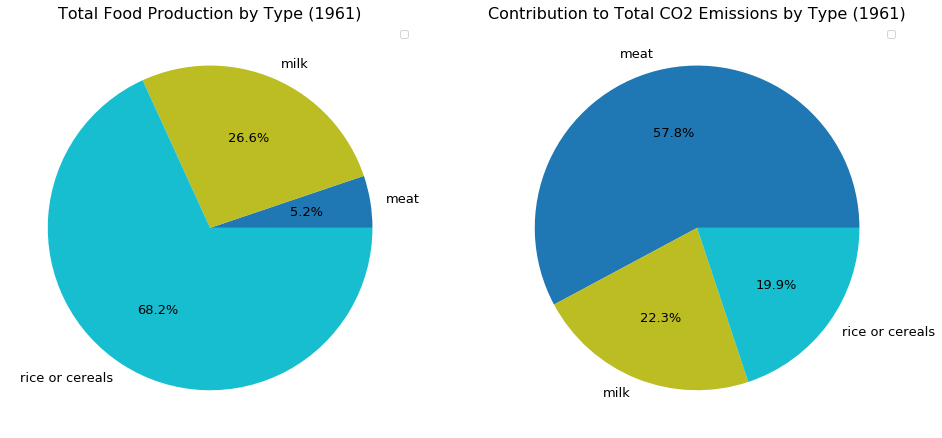

In [101]:
# Plotting the emissions by food type for the year 1961
plot_emissions_food_type(1961)

We observe that there is a great inbalance in the amount of `Emissions intensity` of different food types. For instance, `meat` which represents a very small proportion of the total amount of food produced is responsible for almost 60% of the total food related emissions.

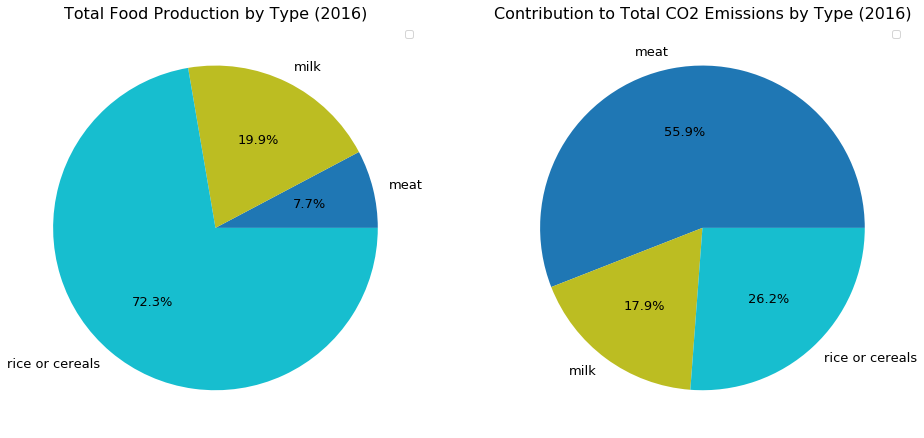

In [106]:
# Plotting the emissions by food type for the year 2016
plot_emissions_food_type(2016)